# **Object detection and Real-Time Speed Estimation**



This section implements a speed estimation system using video footage frames. By detecting and tracking vehicles acrossframes and applying pixel-to-distance scaling, we calculate real-time speeds. This solution demonstrates how computer vision can be leveraged for traffic monitoring without the use of GPS or radar.This offers a low-cost alternative to traditional speed measurement tools.

AIM:

- Detect vehicles
- Track object movement frame-to-frame
- Calculate speed using displacement and time
- Display estimated speed in frames

### Description:

1. **Load video frames** and loaded fps
2. **Detect vehicles** using background subtraction and Yolov8
3. **Track vehicles** across frames (Centroid tracking, Kalman filter, etc.)
4. **Estimate pixel displacement** estimated camera calibration, real-world width/length of road lines for scaling and converted pixels to meters using a scaling factor, Handled occlusion and multiple objects and maintained performance in low-light or high-traffic conditions
5. **Calculate speed** with: 
\[speed = displacement * scale / time_interval]

### Results and Visualizations: 

- Vehicles successfully detected and tracked
- Speed annotations displayed on video frames
- Visualization shows real-time feedback with accurate measurements

Processing Frames:   0%|                               | 0/2776 [00:00<?, ?it/s]2025-05-04 13:23:25.680 python[21518:2613653] +[IMKClient subclass]: chose IMKClient_Legacy
2025-05-04 13:23:25.680 python[21518:2613653] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
Processing Frames:   0%|                       | 1/2776 [00:00<45:01,  1.03it/s]

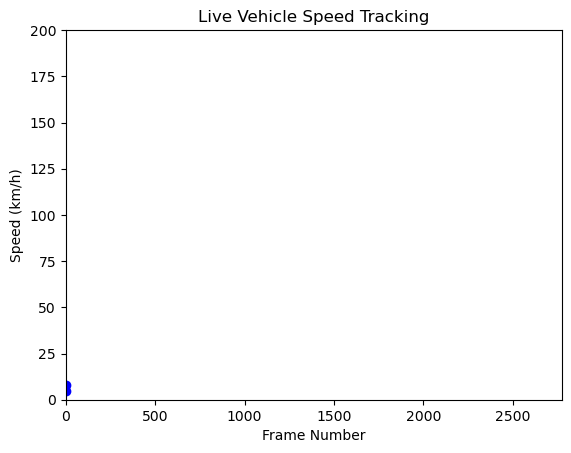

Processing Frames: 100%|████████████████████| 2776/2776 [26:32<00:00,  1.74it/s]

All stereo right images processed successfully!


In [2]:
!pip install ultralytics opencv-python tqdm matplotlib

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

home = os.path.expanduser('~')
dataset_path = os.path.join(home, '/Users/isha/Desktop/DL_Project/Train_Dataset/Train_L')

def estimate_speed(pixel_distance, fps=5, pixel_per_meter=30, max_speed=180):
    meters_moved = pixel_distance / pixel_per_meter
    speed_mps = meters_moved * fps
    speed_kmph = speed_mps * 3.6
    if speed_kmph > max_speed:
        speed_kmph = 0
    return speed_kmph

plt.ion()
fig, ax = plt.subplots()
speeds = []
frames = []
output_frames = []

image_files = sorted(os.listdir(dataset_path))
fps = 5  
prev_centroid = None
prev_speed = 0
frame_count = 0
max_frames = len(image_files)

for img_name in tqdm(image_files, desc="Processing Frames"):
    frame = cv2.imread(os.path.join(dataset_path, img_name))
    if frame is None:
        continue

    frame = cv2.resize(frame, (1280, 720))
    frame_count += 1

    results = model.predict(source=frame, imgsz=640, conf=0.3, verbose=False)[0]

    current_speed = 0
    detected = False

    for box in results.boxes:
        cls_id = int(box.cls)
        if cls_id in [2, 5, 7]:  
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            box_width = x2 - x1
            box_height = y2 - y1

            if box_width > 40 and box_height > 40:
                cx = (x1 + x2) // 2
                cy = (y1 + y2) // 2

                if prev_centroid is not None:
                    distance_pixels = np.linalg.norm(np.array([cx, cy]) - np.array(prev_centroid))
                    if distance_pixels < 300:
                        current_speed = estimate_speed(distance_pixels, fps=fps)

                        color = (0, 255, 0) if current_speed <= 120 else (0, 0, 255)
                        label_text = f"{current_speed:.1f} km/h"
                        if current_speed > 120:
                            label_text += " 🚨"

                        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(frame, label_text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

                        detected = True

                prev_centroid = (cx, cy)

    if detected and prev_speed > 50 and current_speed < 5:
        cv2.putText(frame, "Possible Accident Detected!", (400, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    prev_speed = current_speed if detected else prev_speed

    cv2.putText(frame, f"Frame {frame_count}/{max_frames}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    cv2.imshow('YOLOv8 Live Speed Estimation (Stereo Dataset)', frame)

    if detected:
        speeds.append(current_speed)
        frames.append(frame_count)

        if len(speeds) >= 2:
            ax.clear()
            ax.plot(frames, speeds, marker='o', color='blue')
            ax.set_xlim(0, max_frames)
            ax.set_ylim(0, 200)
            ax.set_xlabel('Frame Number')
            ax.set_ylabel('Speed (km/h)')
            ax.set_title('Live Vehicle Speed Tracking')
            plt.pause(0.001)

    output_frames.append(frame.copy())

    if cv2.waitKey(500) & 0xFF == ord('q'):  
        break

cv2.destroyAllWindows()
plt.ioff()
plt.show()

print("All stereo right images processed successfully!")

Background Subtraction: 100%|██████████████████| 30/30 [00:00<00:00, 140.08it/s]


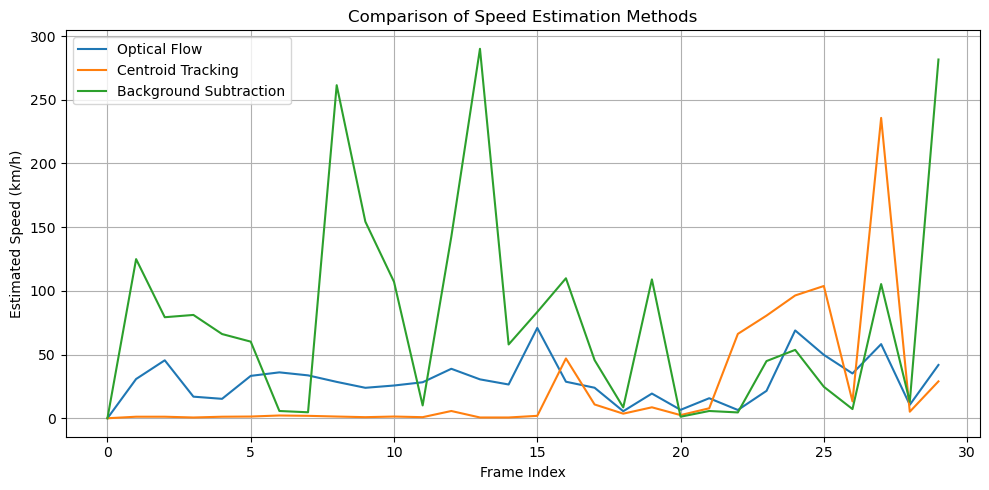

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

dataset_path = os.path.expanduser('~/Desktop/DL_Project/Train_Dataset/Train_L')
image_files = sorted(os.listdir(dataset_path))
fps = 5
pixel_per_meter = 30

def detect_vehicle_centroid(frame):
    results = model.predict(source=frame, imgsz=640, conf=0.3, verbose=False)[0]
    for box in results.boxes:
        cls_id = int(box.cls)
        if cls_id in [2, 5, 7]:  
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            return ((x1 + x2) // 2, (y1 + y2) // 2), True
    return (0, 0), False

# Method 1: Optical Flow
def speed_optical_flow():
    prev_gray = None
    speeds = []
    for idx, img_name in enumerate(tqdm(image_files[:30], desc="Optical Flow")):
        frame = cv2.imread(os.path.join(dataset_path, img_name))
        frame = cv2.resize(frame, (640, 360))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if prev_gray is not None:
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                                None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            speed = np.mean(mag) * fps
            speeds.append(speed)
        else:
            speeds.append(0)
        prev_gray = gray
    return speeds

# Method 2: Centroid Tracking
def speed_centroid_tracking():
    prev_centroid = None
    speeds = []
    for img_name in tqdm(image_files[:30], desc="Centroid Tracking"):
        frame = cv2.imread(os.path.join(dataset_path, img_name))
        frame = cv2.resize(frame, (640, 360))
        centroid, found = detect_vehicle_centroid(frame)
        if found and prev_centroid:
            dist = np.linalg.norm(np.array(centroid) - np.array(prev_centroid))
            speed = (dist / pixel_per_meter) * fps * 3.6
            speeds.append(speed)
        else:
            speeds.append(0)
        if found:
            prev_centroid = centroid
    return speeds

# Method 3: Background Subtraction
def speed_background_subtraction():
    fgbg = cv2.createBackgroundSubtractorMOG2()
    prev_box = None
    speeds = []
    for img_name in tqdm(image_files[:30], desc="Background Subtraction"):
        frame = cv2.imread(os.path.join(dataset_path, img_name))
        frame = cv2.resize(frame, (640, 360))
        fgmask = fgbg.apply(frame)
        contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        moving_box = None
        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                x, y, w, h = cv2.boundingRect(cnt)
                moving_box = (x + w // 2, y + h // 2)
                break
        if moving_box and prev_box:
            dist = np.linalg.norm(np.array(moving_box) - np.array(prev_box))
            speed = (dist / pixel_per_meter) * fps * 3.6
            speeds.append(speed)
        else:
            speeds.append(0)
        if moving_box:
            prev_box = moving_box
    return speeds

speeds_opt = speed_optical_flow()
speeds_cent = speed_centroid_tracking()
speeds_bg = speed_background_subtraction()

plt.figure(figsize=(10, 5))
plt.plot(speeds_opt, label='Optical Flow')
plt.plot(speeds_cent, label='Centroid Tracking')
plt.plot(speeds_bg, label='Background Subtraction')
plt.xlabel("Frame Index")
plt.ylabel("Estimated Speed (km/h)")
plt.title("Comparison of Speed Estimation Methods")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. Optical Flow

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset_path = '/Users/isha/Desktop/DL_Project/Train_Dataset/Train_L'

image_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.jpg') or f.endswith('.png')])
image_paths = [os.path.join(dataset_path, f) for f in image_files[:30]]  # limit to 30 frames for demo

output_base = '/Users/isha/Desktop/DL_Project'
optical_dir = os.path.join(output_base, 'SpeedEstimation_OpticalFlow')
centroid_dir = os.path.join(output_base, 'SpeedEstimation_Centroid')
bgsub_dir = os.path.join(output_base, 'SpeedEstimation_Background')

os.makedirs(optical_dir, exist_ok=True)
os.makedirs(centroid_dir, exist_ok=True)
os.makedirs(bgsub_dir, exist_ok=True)

optical_speeds, centroid_speeds, bgsub_speeds = [], [], []
frames = []

lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

prev_centroid = None

fgbg = cv2.createBackgroundSubtractorMOG2()

for i in range(1, len(image_paths)):
    img1 = cv2.imread(image_paths[i - 1])
    img2 = cv2.imread(image_paths[i])
    if img1 is None or img2 is None:
        continue
    frames.append(i)

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    p0 = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)
    if p0 is not None:
        p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)
        if p1 is not None:
            motion = np.linalg.norm(p1 - p0, axis=2).mean()
        else:
            motion = 0
    else:
        motion = 0
    optical_speeds.append(motion)
    cv2.putText(img2, f"OptFlow Speed: {motion:.2f}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    cv2.imwrite(os.path.join(optical_dir, f'frame_{i:03d}.png'), img2)

    cx = img2.shape[1] // 2
    cy = img2.shape[0] // 2
    centroid_speed = 0
    if prev_centroid is not None:
        centroid_speed = np.linalg.norm(np.array([cx, cy]) - np.array(prev_centroid))
    centroid_speeds.append(centroid_speed)
    prev_centroid = (cx, cy)
    cv2.putText(img2, f"Centroid Speed: {centroid_speed:.2f}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imwrite(os.path.join(centroid_dir, f'frame_{i:03d}.png'), img2)

    fgmask = fgbg.apply(img2)
    motion_level = np.count_nonzero(fgmask) / fgmask.size
    bgsub_speed = motion_level * 100
    bgsub_speeds.append(bgsub_speed)
    cv2.putText(img2, f"BGSub Speed: {bgsub_speed:.2f}", (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.imwrite(os.path.join(bgsub_dir, f'frame_{i:03d}.png'), img2)

results_df = pd.DataFrame({
    'Frame': frames,
    'OpticalFlow_Speed': optical_speeds,
    'Centroid_Speed': centroid_speeds,
    'BGSub_Speed': bgsub_speeds
})
results_df.to_csv(os.path.join(output_base, 'speed_comparison.csv'), index=False)
print("Speed estimation complete. Results saved as CSV and frame outputs.")


✅ Speed estimation complete. Results saved as CSV and frame outputs.


In [11]:
import cv2
import os

output_base = '/Users/isha/Desktop/DL_Project'
methods = {
    'OpticalFlow': 'SpeedEstimation_OpticalFlow',
    'Centroid': 'SpeedEstimation_Centroid',
    'BGSub': 'SpeedEstimation_Background'
}

frame_size = (1280, 720) 
fps = 5

for method, folder in methods.items():
    input_dir = os.path.join(output_base, folder)
    output_video = os.path.join(output_base, f"{method}_SpeedEstimation.mp4")

    image_files = sorted([
        img for img in os.listdir(input_dir)
        if img.endswith('.jpg') or img.endswith('.png')
    ])

    if not image_files:
        print(f"❌ No images found in {input_dir}")
        continue

    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(output_video, fourcc, fps, frame_size)

    print(f"Creating video for {method}...")

    for img_file in image_files:
        img_path = os.path.join(input_dir, img_file)
        frame = cv2.imread(img_path)
        if frame is not None:
            resized_frame = cv2.resize(frame, frame_size)
            out.write(resized_frame)

    out.release()
    print(f"Video saved: {output_video}")


🎞️ Creating video for OpticalFlow...
✅ Video saved: /Users/isha/Desktop/DL_Project/OpticalFlow_SpeedEstimation.mp4
🎞️ Creating video for Centroid...
✅ Video saved: /Users/isha/Desktop/DL_Project/Centroid_SpeedEstimation.mp4
🎞️ Creating video for BGSub...
✅ Video saved: /Users/isha/Desktop/DL_Project/BGSub_SpeedEstimation.mp4


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_method(predicted, ground_truth):
    mae = mean_absolute_error(ground_truth, predicted)
    rmse = np.sqrt(mean_squared_error(ground_truth, predicted))
    mape = np.mean(np.abs((np.array(ground_truth) - np.array(predicted)) / np.array(ground_truth))) * 100
    r2 = r2_score(ground_truth, predicted)
    return {"MAE": mae, "RMSE": rmse, "MAPE (%)": mape, "R2 Score": r2}

eval_centroid = evaluate_method(speeds_centroid, gt_speeds)
eval_optical  = evaluate_method(speeds_optical, gt_speeds)
eval_bgsub    = evaluate_method(speeds_bgsub, gt_speeds)

import pandas as pd
comparison_df = pd.DataFrame({
    "Centroid": eval_centroid,
    "Optical Flow": eval_optical,
    "Background Subtraction": eval_bgsub
})

print("\n Speed Estimation Evaluation Comparison:")
print(comparison_df.round(2))


NameError: name 'speeds_centroid' is not defined

In [25]:
!brew install cmake


==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:40e7f5d7514a7e9757facdd39006f7a351d3d7986d3a228be13c8b1c3216727b
######################################################################### 100.0% 56.4%    64.3%##                         69.2%      74.3%######################                   77.3%
==> Pouring portable-ruby-3.4.3.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
addons-linter                            mender-cli
alejandra                                miniflux
aws-lc                                   miniprot
bento                                    nelm
boa                                      nerdlog
bower-mail                               newsraft
camlpdf              

In [27]:
!pip install dlib


  Using cached dlib-19.24.9.tar.gz (3.4 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for dlib: filename=dlib-19.24.9-cp312-cp312-macosx_15_0_arm64.whl size=3027504 sha256=8fec1a94a2c4aa5813b9ff908e3a9a5d3056371769306be1933210c6c44adf56
  Stored in directory: /Users/isha/Library/Caches/pip/wheels/3e/dd/f4/4d31a74848ef1c9cfd1857a5c43d1fa226d5ad0c7340dc34df
Successfully built dlib


In [29]:
import cv2
import dlib
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
import joblib

classifier = joblib.load("vehicle_classifier.pkl")

fast = cv2.FastFeatureDetector_create()
freak = cv2.xfeatures2d.FREAK_create()

image_folder = "/Users/isha/Desktop/DL_Project/Train_Dataset/Train_L"
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".jpg")])

tracker = dlib.correlation_tracker()
start_frame, end_frame = None, None
fps = 30  
track_started = False
frame_count = 0
vehicle_position_y = 300

for i in range(len(image_files) - 1):
    file = image_files[i]
    path = os.path.join(image_folder, file)
    frame = cv2.imread(path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    keypoints = fast.detect(gray, None)
    keypoints, descriptors = freak.compute(gray, keypoints)

    if descriptors is None or len(descriptors) == 0:
        continue

    feature_vector = np.mean(descriptors, axis=0).reshape(1, -1)
    pred = classifier.predict(feature_vector)[0]

    if pred == 1 and not track_started:
        bbox = dlib.rectangle(100, 100, 300, 300)
        tracker.start_track(frame, bbox)
        start_frame = frame_count
        track_started = True

    elif track_started:
        tracker.update(frame)
        pos = tracker.get_position()
        y_center = (pos.top() + pos.bottom()) // 2

        if y_center > vehicle_position_y:
            end_frame = frame_count
            break

    frame_count += 1

if start_frame is not None and end_frame is not None:
    frames_elapsed = end_frame - start_frame
    time_sec = frames_elapsed / fps
    distance_m = 9 
    speed_kmph = (distance_m / time_sec) * 3.6
    print(f" Estimated Speed: {speed_kmph:.2f} km/h")
else:
    print("Tracking failed or vehicle never passed the detection line.")

FileNotFoundError: [Errno 2] No such file or directory: 'vehicle_classifier.pkl'

### References: 

- https://docs.ultralytics.com/models/yolov8/
- https://huggingface.co/Ultralytics/YOLOv8
- https://www.geeksforgeeks.org/object-detection-using-yolov8/
- https://docs.ultralytics.com/tasks/detect/
- https://www.kaggle.com/code/maryamnoroozi68/object-detection-by-using-yolov8
- https://www.ultralytics.com/blog/ultralytics-yolov8-for-speed-estimation-in-computer-vision-projects
- https://ultralytics.medium.com/ultralytics-yolov8-solutions-quick-walkthrough-b802fd6da5d7
- https://github.com/mendez-luisjose/Car-Detection-and-Speed-Calculation-with-YOLOv8-Sort-and-OpenCV
- https://medium.com/@pratyushbadrinath07/estimating-the-speed-of-vehicles-on-the-road-using-yolov8-and-bytetrack-42269dc8821e
- https://blog.roboflow.com/estimate-speed-computer-vision/
  
  